In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/My Drive/broutanlab_course/

Mounted at /content/drive
/content/drive/My Drive/broutanlab_course


In [2]:
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import os
from imutils import paths
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


#Dataset

In [36]:
dataset = 'dataset4m'

In [37]:
names = os.listdir(dataset)
n_classes = len(names)
n_classes

5

In [38]:
imagePaths = list(paths.list_images(dataset))
idendities = {names[0]:[],names[1]:[], names[2]:[],names[3]:[],names[4]:[]}
for (i, imagePath) in enumerate(imagePaths):
  idendities[imagePath.split(os.path.sep)[-2]].append(imagePath)


# Positive samples

In [39]:

positives = []

for key, values in idendities.items():
    
    #print(key)
    for i in range(0, len(values)-1):
        for j in range(i+1, len(values)):
            #print(values[i], " and ", values[j])
            positive = []
            positive.append(values[i])
            positive.append(values[j])
            positives.append(positive)

In [40]:
positives = pd.DataFrame(positives, columns = ["file_x", "file_y"])
positives["decision"] = "Yes"

## Negative samples

In [41]:
samples_list = list(idendities.values())


In [42]:
negatives = []

for i in range(0, len(idendities) - 1):
    for j in range(i+1, len(idendities)):
        #print(samples_list[i], " vs ",samples_list[j]) 
        cross_product = itertools.product(samples_list[i], samples_list[j])
        cross_product = list(cross_product)
        #print(cross_product)
        
        for cross_sample in cross_product:
            #print(cross_sample[0], " vs ", cross_sample[1])
            negative = []
            negative.append(cross_sample[0])
            negative.append(cross_sample[1])
            negatives.append(negative)

In [43]:
negatives = pd.DataFrame(negatives, columns = ["file_x", "file_y"])
negatives["decision"] = "No"

## Merge Positives and Negative Samples

In [44]:
df = pd.concat([positives, negatives]).reset_index(drop = True)

In [45]:
df.shape

(190, 3)

In [46]:

df.decision.value_counts()

No     160
Yes     30
Name: decision, dtype: int64

## DeepFace

In [47]:
pip install deepface

In [48]:
from deepface import DeepFace

In [49]:
instances = df[["file_x", "file_y"]].values.tolist()

In [50]:
model_name = "VGG-Face"
distance_metric = "cosine"

In [51]:
resp_obj = DeepFace.verify(instances, model_name = model_name, distance_metric = distance_metric)




Verification:   0%|          | 0/190 [00:00<?, ?it/s]

Verification:   1%|          | 1/190 [00:07<22:34,  7.17s/it]

Verification:   1%|          | 2/190 [00:10<18:46,  5.99s/it]

Verification:   2%|▏         | 3/190 [00:14<16:25,  5.27s/it]

Verification:   2%|▏         | 4/190 [00:19<16:08,  5.20s/it]

Verification:   3%|▎         | 5/190 [00:24<16:09,  5.24s/it]

Verification:   3%|▎         | 6/190 [00:27<14:03,  4.58s/it]

Verification:   4%|▎         | 7/190 [00:30<12:52,  4.22s/it]

Verification:   4%|▍         | 8/190 [00:33<11:42,  3.86s/it]

Verification:   5%|▍         | 9/190 [00:37<11:04,  3.67s/it]

Verification:   5%|▌         | 10/190 [00:40<10:21,  3.46s/it]

Verification:   6%|▌         | 11/190 [00:43<09:55,  3.33s/it]

Verification:   6%|▋         | 12/190 [00:45<09:29,  3.20s/it]

Verification:   7%|▋         | 13/190 [00:49<10:09,  3.44s/it]

Verification:   7%|▋         | 14/190 [00:54<10:53,  3.71s/it]

Verification:   8%|▊         | 15/190 [00:57<10:26,  3.5

In [52]:

distances = []
for i in range(0, len(instances)):
    distance = round(resp_obj["pair_%s" % (i+1)]["distance"], 4)
    distances.append(distance)

In [53]:
df["distance"] = distances


## Analyzing Distances

In [54]:
tp_mean = round(df[df.decision == "Yes"].mean().values[0], 4)
tp_std = round(df[df.decision == "Yes"].std().values[0], 4)
fp_mean = round(df[df.decision == "No"].mean().values[0], 4)
fp_std = round(df[df.decision == "No"].std().values[0], 4)


In [55]:
print("Std of true positives: ", tp_std)
print("Mean of false positives: ", fp_mean)
print("Std of false positives: ", fp_std)

Std of true positives:  0.2146
Mean of false positives:  0.6982
Std of false positives:  0.1778


## Distribution

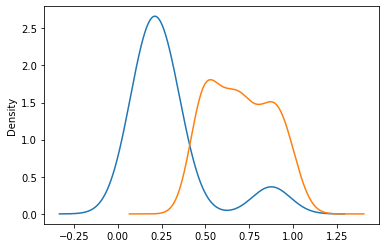

In [56]:
df[df.decision == "Yes"].distance.plot.kde()
df[df.decision == "No"].distance.plot.kde()

## Best Split Point

In [72]:
pip install chefboost

In [73]:
from chefboost import Chefboost as chef

In [74]:
config = {'algorithm': 'C4.5'}

In [75]:
tmp_df = df[['distance', 'decision']].rename(columns = {"decision": "Decision"}).copy()
model = chef.fit(tmp_df, config)

C4.5  tree is going to be built...
-------------------------
finished in  0.522850513458252  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  98.42105263157895 % on  190  instances
Labels:  ['Yes' 'No']
Confusion matrix:  [[27, 0], [3, 160]]
Precision:  100.0 %, Recall:  90.0 %, F1:  94.7368 %


## Sigma

In [76]:
sigma = 2
#2 sigma corresponds 95.45% confidence, and 3 sigma corresponds 99.73% confidence

#threshold = round(tp_mean + sigma * tp_std, 4)
threshold = 0.3147 #comes from c4.5 algorithm
print("threshold: ", threshold)

threshold:  0.3147


In [77]:
df[df.decision == 'Yes'].distance.max()

0.8849

In [78]:

df[df.decision == 'No'].distance.min()

0.4004

## Evaluation

In [79]:
df["prediction"] = "No"

In [80]:

idx = df[df.distance <= threshold].index
df.loc[idx, 'prediction'] = 'Yes'

In [81]:
df.sample(5)

,file_x,file_y,decision,distance,prediction
130,dataset4m/Ariana Grande/585-ariana_grande.jpg,dataset4m/Ryan Gosling/MV5BMTQzMjkwNTQ2OF5BMl5...,No,0.6628,No
172,dataset4m/Avril Lavigne/avril-lavigne.jpg,dataset4m/Ryan Gosling/actor-ryan-gosling-atte...,No,0.8273,No
164,dataset4m/Avril Lavigne/4526d50b2776bac0126824...,dataset4m/Ryan Gosling/actor-ryan-gosling-atte...,No,0.6714,No
170,dataset4m/Avril Lavigne/avril-lavigne.jpg,dataset4m/Ryan Gosling/MV5BMTQzMjkwNTQ2OF5BMl5...,No,0.8118,No
112,dataset4m/Ariana Grande/pic1.png,dataset4m/Selena Gomez/selena-gomez.jpg,No,0.5907,No


In [82]:
cm = confusion_matrix(df.decision.values, df.prediction.values)

In [83]:
cm

array([[160,   0],
       [  5,  25]])

In [84]:
tn, fp, fn, tp = cm.ravel()

In [85]:

tn, fp, fn, tp

(160, 0, 5, 25)

In [86]:
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn)/(tn + fp +  fn + tp)
f1 = 2 * (precision * recall) / (precision + recall)

In [87]:
print("Precision: ", 100*precision,"%")
print("Recall: ", 100*recall,"%")
print("F1 score ",100*f1, "%")
print("Accuracy: ", 100*accuracy,"%")

Precision:  100.0 %
Recall:  83.33333333333334 %
F1 score  90.9090909090909 %
Accuracy:  97.36842105263158 %


In [88]:
df.to_csv("threshold_pivot.csv", index = False)